This notebook analyses data from Bpod.

Tested on output of protocol 'Two_Alternative_Choice'

In [6]:
%load_ext autoreload
%autoreload 2
from utils import custom_functions, plot_utils
import os
import sys
sys.path.append("../") # go to parent 
import Bpod_OE_Francesca.utils.load_nested_structs as load_ns
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def ReadAnimalData(GeneralDirectory, AnimalID, BpodProtocol, printout = True):
    # Reads all data from one animal and one protocol
    
    # Initialize return lists
    ExperimentFiles = [] # to store experiment names
    ExperimentData = [] # to store the dictionaries
    ntrialsDistribution = [] # to visualize the distribution of the number of trials
    Protocols = [] # store the protocols
    Stimulations = [] # store the stimulated protocols
    counter = 0
    for file in glob.glob(GeneralDirectory+AnimalID + BpodProtocol +'Session Data/*.mat'):
        # Read data
        data = load_ns.loadmat(file)
        
        # if that session is empty skip it:
        if not 'nTrials' in data['SessionData']:
            continue
        
        ntrials = data['SessionData']['nTrials'] # this sometimes fails if the session is empty

        ExperimentFiles.append(file)
        # Parse the settings of the trials
        trial_raw_events = data['SessionData']['TrialSettings']
        for trial_num, trial in enumerate(trial_raw_events):
            trial_raw_events[trial_num] = load_ns._todict(trial)
        data['SessionData']['TrialSettings'] = trial_raw_events

        # Get info for the settings from the first trial
        try:
            protocol = trial_raw_events[0]['GUIMeta']['TrainingLevel']['String'][
                trial_raw_events[0]['GUI']['TrainingLevel'] - 1]
        except:
            protocol = 'Unknown'

        try:
            stimulation = trial_raw_events[0]['GUIMeta']['OptoStim']['String'][
                trial_raw_events[0]['GUI']['OptoStim'] - 1]
        except:
            stimulation = 'unknown'
        
        if printout:
            print('{}: {}, {} trials on protocol {}, stimulation {}'.format(counter, ntpath.basename(file), ntrials, protocol, stimulation))
        
        ntrialsDistribution.append(ntrials)
        Protocols.append(protocol)
        Stimulations.append(stimulation)

        # as RawEvents.Trial is a cell array of structs in MATLAB, we have to loop through the array and convert the structs to dicts
        trial_raw_events = data['SessionData']['RawEvents']['Trial']
        for trial_num, trial in enumerate(trial_raw_events):
            trial_raw_events[trial_num] = load_ns._todict(trial)
        data['SessionData']['RawEvents']['Trial'] = trial_raw_events

        # Save the data in a list
        ExperimentData.append(data)
        counter+=1
        
    return ExperimentFiles, ExperimentData, ntrialsDistribution, Protocols, Stimulations

In [3]:
# Select animal to analyze
AnimalID = 'Ot01'
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

# Create out directory if it does not exist
outputDir = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

0: Ot01_Two_Alternative_Choice_20190312_164402.mat, 292 trials on protocol Habituation, stimulation NoStimulation
1: Ot01_Two_Alternative_Choice_20190313_173329.mat, 456 trials on protocol Visual, stimulation NoStimulation
2: Ot01_Two_Alternative_Choice_20190314_174311.mat, 659 trials on protocol Visual, stimulation NoStimulation
3: Ot01_Two_Alternative_Choice_20190315_165650.mat, 381 trials on protocol Visual, stimulation NoStimulation
4: Ot01_Two_Alternative_Choice_20190318_170754.mat, 491 trials on protocol Visual, stimulation NoStimulation
5: Ot01_Two_Alternative_Choice_20190320_154920.mat, 444 trials on protocol Visual, stimulation Right
6: Ot01_Two_Alternative_Choice_20190321_160618.mat, 325 trials on protocol Auditory, stimulation NoStimulation
7: Ot01_Two_Alternative_Choice_20190322_143045.mat, 648 trials on protocol Auditory, stimulation NoStimulation
8: Ot01_Two_Alternative_Choice_20190325_160701.mat, 384 trials on protocol Auditory, stimulation NoStimulation
9: Ot01_Two_Alte

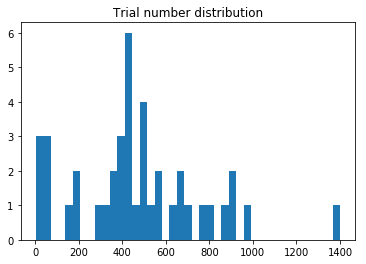

In [4]:
# Read data
ExperimentFiles, ExperimentData,\
ntrialsDistribution, Protocols, Stimulations =\
ReadAnimalData(GeneralDirectory, AnimalID, BpodProtocol, printout = True)

# get the date and time from the files
ExperimentTimes = custom_functions.ParseForTimes(ExperimentFiles)
ExperimentDates = custom_functions.ParseForDates(ExperimentFiles)
# Transform to e.g. Feb20
ExperimentDatesPretty = custom_functions.MakeDatesPretty(ExperimentTimes)

# plot number of trials    
plt.hist(ntrialsDistribution, bins=len(ExperimentFiles))
plt.title('Trial number distribution')
plt.show()

In [8]:
# Clean data
# Remove those experiments fow which a proper time has not been found (old ones that are missing a lot of variables)
# Or those with low number of trials
idxToRemove = custom_functions.identifyIdx(ExperimentTimes, ntrialsDistribution, 30)

for idx in idxToRemove:
    print('deleting data for {} with {} trials'.format(ntpath.basename(ExperimentFiles[idx]), ntrialsDistribution[idx]))
    ExperimentData.pop(idx)
    ExperimentDates.pop(idx)
    ExperimentDatesPretty.pop(idx)
    ExperimentFiles.pop(idx)
    ExperimentTimes.pop(idx)
    ntrialsDistribution.pop(idx)
    Protocols.pop(idx)
    Stimulations.pop(idx)

deleting data for Ot01_Two_Alternative_Choice_20190413_154814.mat with 3 trials
deleting data for Ot01_Two_Alternative_Choice_20190405_154245.mat with 2 trials
deleting data for Ot01_Two_Alternative_Choice_20190401_152504.mat with 4 trials


In [9]:
# get all data into a dataframe
DataFrames = [custom_functions.SessionDataToDataFrame(AnimalID, ExperimentDatesPretty[i], exp['SessionData'])
              for i,exp in enumerate(ExperimentData)]

AnimalDF = pd.concat(DataFrames, ignore_index=True)

# save the dataframe
AnimalDF.to_pickle(outputDir + AnimalID + '_dataframe.pkl')

In [ ]:
# read it like this:
AnimalDF = pd.read_pickle(outputDir + AnimalID + '_dataframe.pkl')

In [10]:
# function to process the data of an experiment for psychometric performance plots:
def PP_ProcessExperiment(SessionData, bootstrap = True):
    # SessionData is a dataframe that needs to have the following column names:
    # 'OptoStim'
    # 'TrialHighPerc'
    # 'FirstPoke'    
    
    # Split data into normal and opto trials
    #ExpNor, ExpOp = custom_functions.splitOpto(SessionData=SessionData)
    ExpNorDif = np.array(SessionData[SessionData['OptoStim']==0]['TrialHighPerc'])
    ExpNorSidSel = np.array(SessionData[SessionData['OptoStim']==0]['FirstPoke'])
    ExpOptDif = np.array(SessionData[SessionData['OptoStim']==1]['TrialHighPerc'])
    ExpOptSidSel = np.array(SessionData[SessionData['OptoStim']==1]['FirstPoke'])
    
    
    # Calculate psychometric performance parameters for each
    Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNorDif, sideSelected = ExpNorSidSel)
    Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOptDif, sideSelected = ExpOptSidSel)
    # predict data
    predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)
    if Normal_PsyPer:
        Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
    else: # needed for the return
        Normal_predictPer = np.nan            
    if Opto_PsyPer:
        Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]
    else: # needed for the return
        Opto_predictPer = np.nan
    # Bootstrap on fake data (generated inside the bootstrap function)
    Normal_fakePredictions = np.nan
    Opto_fakePredictions = np.nan
    if bootstrap:
        bootstrap_ntimes = 1000
        np.random.seed(12233)  # fixed random seed for reproducibility
        if Normal_PsyPer:
            Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNorDif,
                                                                            sideSelected = ExpNorSidSel,
                                                                            ntimes = bootstrap_ntimes,
                                                                            prediction_difficulties = predictDif)            
        if Opto_PsyPer:
            Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOptDif,
                                                                            sideSelected = ExpOptSidSel,
                                                                            ntimes = bootstrap_ntimes,
                                                                            prediction_difficulties = predictDif)            

    # return what is needed for the plot
    return predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, Opto_PsyPer, \
    Opto_fakePredictions, Opto_predictPer
    

In [11]:
# Make a summary plot of the sesssions and performances using all data! (TODO)

# Initialize lists to save important data
DifficultyValues = []
PerformanceValues = []

# process data from all experiments
for counter, session in enumerate(pd.unique(AnimalDF['SessionTime'])):    
    predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, \
    Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = PP_ProcessExperiment(AnimalDF[AnimalDF['SessionTime']==session],
                                                                           bootstrap=False)

    #append to lists, only the normal trials
    DifficultyValues.append(Normal_PsyPer['Difficulty'])
    PerformanceValues.append(Normal_PsyPer['Performance'])

    update_progress(counter / len(pd.unique(AnimalDF['SessionTime'])))
    
update_progress(1)


# calculate difficulty levels
difLevels = np.unique(np.concatenate(DifficultyValues).ravel())
# Initialize the matrix
matToPlot = np.full([len(difLevels), len(DifficultyValues)], np.nan)
# Loop to fill it
for i, dif in enumerate(difLevels):
    for j, per in enumerate(PerformanceValues):
        if dif in DifficultyValues[j]:
            idxOfDif = np.where(DifficultyValues[j]==dif)[0][0]
            matToPlot[i,j] = per[idxOfDif]

# Transform to dataframe
dfToPlot = pd.DataFrame(matToPlot)
dfToPlot = dfToPlot.set_index(difLevels) # set row names
dfToPlot.columns = pd.unique(AnimalDF['SessionTime']) # set col names 

Progress: [####################] 100.0%


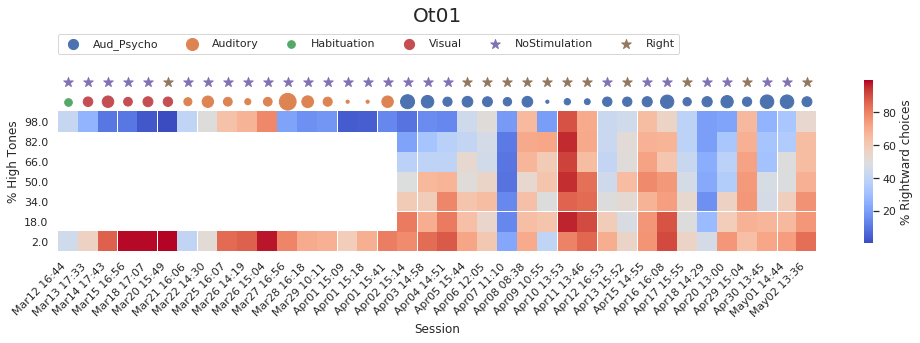

In [12]:
# plot it
sns.set(style="white")
fig, ax = plt.subplots(figsize=(17,5))
sns.heatmap(dfToPlot, linewidth=0.001, square=True, cmap="coolwarm",
            cbar_kws={"shrink": 0.6, 'label': '% Rightward choices'})
# label the number of trials and type of protocol
# TODO: check that the size is proportional (area vs radius)
# recalculate the number of trials as some might get grouped if they are on the same day. Do all below with the dataframe
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x + 0.5 for x in protIdx], np.repeat(len(difLevels)+0.5, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
# label the opto trials
for st_counter, stim in enumerate(np.unique(Stimulations)):
    stimIdx = [i for i, x in enumerate(Stimulations) if x == stim]
    ax.scatter([x + 0.5 for x in stimIdx], np.repeat(len(difLevels)+1.5, len(stimIdx)), marker='*', s=100, label = stim)
ax.legend(loc=(0,1.1), borderaxespad=0., ncol = pr_counter+st_counter+2, frameon=True)
ax.set_ylim([0, len(difLevels)+2])
plt.ylabel('% High Tones')
plt.xlabel('Session')
plt.yticks(rotation=0)
plt.xticks(horizontalalignment="right", rotation=45)
plt.title(AnimalID + '\n\n', fontsize=20, fontweight=0)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,
            dpi = 500, bbox_inches='tight')
plt.show(fig)

In [ ]:
# Make a plot with the performance for all sessions

fig, axs = plt.subplots(math.ceil(len(ExperimentData)/4), 4, figsize=(15, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()


# process data from all experiments
for counter, session in enumerate(np.unique(AnimalDF['SessionTime'])):    
    predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, \
    Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = PP_ProcessExperiment(AnimalDF[AnimalDF['SessionTime']==session])
    
    if Normal_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs[counter], fakePred = Normal_fakePredictions,
                         realPred = Normal_predictPer, color = 'c', label = 'normal')

    if Opto_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                             predictDif = predictDif, ax = axs[counter], fakePred = Opto_fakePredictions,
                             realPred = Opto_predictPer, color = 'm', label = 'opto')
        
    axs[counter].get_legend().remove()
    axs[counter].text(.5,.95, AnimalID + ' ' + str(counter) + ': ' + str(session), \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.85, Protocols[counter] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, 'No of trials: ' + str(ntrialsDistribution[counter]) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].set_ylabel('')
    axs[counter].set_xlabel('')

    update_progress(counter / len(np.unique(AnimalDF['SessionTime'])))
    
update_progress(1)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [ ]:
# Group sessions by type and plot them together
protToGroup = 'Aud_Psycho'
stimToGroup = 'Right'

pulledData = AnimalDF[(AnimalDF['Protocol']==protToGroup) & (AnimalDF['Stimulation']==stimToGroup)]

predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, \
Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = PP_ProcessExperiment(pulledData)

fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(np.unique(pulledData['SessionTime'])))

plt.savefig(outputDir + AnimalID + '_' + protToGroup + '_' + stimToGroup + '_grouped_psychometricPerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)

In [ ]:
# TODO:
# Remove trials when the animal is not engaged



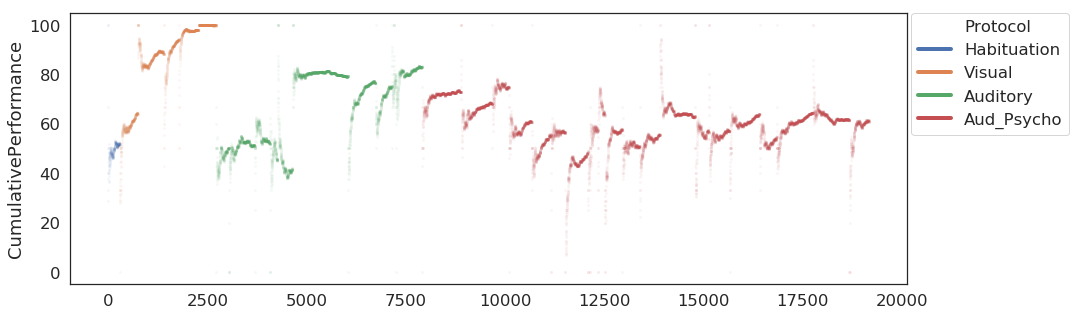

In [30]:
# plot the evolution of the cumulative performance
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x = AnimalDF.index, y = 'CumulativePerformance', data=AnimalDF, hue = 'Protocol',
             marker=".", alpha = 0.05, markeredgewidth=0, linewidth=0)

lgd=plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + AnimalID + '_CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
# Analyze this with the optotrials as well
def AnalyzeSwithTrials(df):
    # df is a dataframe containing the following columns:
    # 'SwitchSide'
    # 'FirstPokeCorrect'
    # 'SessionTime'
    # 'OptoStim'
    # it returns a different dataframe with information grouped for a bar plot
    
    # get info for the sessions
    sessionsID = np.unique(df['SessionTime'])
    # initialize list to hold dataframes
    sessionsInfo = []    
    
    # fill the new dataframe with info for each session
    for session in sessionsID:
        # get the dataframe for that session
        Sdf = df[df['SessionTime']==session]
        # split the dataset into opto and normal
        Ndf = Sdf[df['OptoStim']==0]
        Odf = Sdf[df['OptoStim']==1]
        # percentage of correct trials on stay trials without stimulation
        StayNoStim = 100 * np.sum(Ndf[Ndf['SwitchSide']==0]['FirstPokeCorrect']==1)/len(Ndf[Ndf['SwitchSide']==0])
        # percentage of correct trials on switch trials without stimulation
        SwitchNoStim = 100 * np.sum(Ndf[Ndf['SwitchSide']==1]['FirstPokeCorrect']==1)/len(Ndf[Ndf['SwitchSide']==1])
        # percentage of correct trials on stay trials with stimulation
        StayStim = 100 * np.sum(Odf[Odf['SwitchSide']==0]['FirstPokeCorrect']==1)/len(Odf[Odf['SwitchSide']==0])
        # percentage of correct trials on switch trials with stimulation
        SwitchStim = 100 * np.sum(Odf[Odf['SwitchSide']==1]['FirstPokeCorrect']==1)/len(Odf[Odf['SwitchSide']==1])
        # fill the dataframe
        SessionDF = pd.DataFrame({'SessionTime': np.repeat(session, 4),
                                  'Condition': np.array(['Normal_noSwitch', 'Normal_Switch', 'Opto_noSwitch', 'Opto_Switch']),
                                  'PercCorrect': np.array([StayNoStim, SwitchNoStim, StayStim, SwitchStim])
                                 })
        # append it to list
        sessionsInfo.append(SessionDF)
        
    # merge into a single df and return
    return pd.concat(sessionsInfo, ignore_index=True)

In [ ]:
# Separate between trials that are ocurring in a row and those that the animal has to switch (repetitive vs new side)
dfForBP = AnalyzeSwithTrials(AnimalDF)

In [ ]:
fig, ax = plt.subplots(figsize=(17,5))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 0, "alpha": 0.01})
sns.barplot(x='SessionTime', y='PercCorrect', hue='Condition', data=dfForBP)
# label the type of trials
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x for x in protIdx], np.repeat(105, len(protIdx)), marker='o',
               s=[ntrialsDistribution[x]/5 for x in protIdx], label = prot) 
plt.legend(loc=(0,1.1), borderaxespad=0., ncol = 4, frameon=True)
plt.xticks(horizontalalignment="right", rotation=45)
plt.show()




Go step by step:

In [ ]:
# select a session
x = 13

In [ ]:
# Split data into normal and opto trials
ExpNor, ExpOp = custom_functions.splitOpto(ExperimentData[x]['SessionData'])

In [ ]:
# Calculate psychometric performance parameters for each
Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])

In [ ]:
# predict data
predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)

if Normal_PsyPer:
    Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
if Opto_PsyPer:
    Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]

In [ ]:
# Bootstrap on fake data (generated inside the bootstrap function)
bootstrap_ntimes = 1000
np.random.seed(12233)  # fixed random seed for reproducibility

if Normal_PsyPer:
    Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                    sideSelected = ExpNor['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)
if Opto_PsyPer:
    Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                    sideSelected = ExpOp['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(x) + ': ' + ExperimentTimes[x])

plt.savefig(outputDir + AnimalID + '_' + ExperimentTimes[x] + '_psychometricPerformance.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)